In [185]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_trattati.csv' # cleaned data
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_with_context.csv' # cleaned data
df = pd.read_csv(file_path)
df['datadate'] = pd.to_datetime(df['datadate'])
df['datadate'] = df['datadate'] + pd.offsets.QuarterEnd(0)
df['divyield_Median'] = df['divyield_Median'].replace('%', '', regex=True).astype(float)

# Define columns to keep
keep_cols = ['datadate','tic', 'FFI10_desc', 'relative_quarterly_return']

df = df[keep_cols]

# Drop rows with missing values
df = df.dropna()

# Display dataframe info
df.head()

,datadate,tic,FFI10_desc,relative_quarterly_return
0,1970-03-31,F,DURBL,0.138857
1,1970-03-31,COP,ENRGY,-0.004692
2,1970-03-31,XOM,ENRGY,-0.046479
3,1970-03-31,CVX,ENRGY,-0.103189
4,1970-03-31,OXY,ENRGY,-0.071040


In [186]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import random
from contextualized.easy import ContextualizedRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters
num_stocks = 100
num_industries = 10
embedding_dim = 4
epochs = 500
lr = 0.01
reg_strength = 0.2  # weight for clustering loss

# Dummy stock-to-industry mapping (e.g. stocks 0–9 → industry 0, etc.)
stock_to_industry = torch.tensor([i // 10 for i in range(num_stocks)])

# Dummy prediction targets (e.g. simulate returns or labels)
# Just for training purposes — replace with real data
true_targets = torch.randn(num_stocks, 1)  # regression target per stock

# Dataset (each sample is one stock)
stock_ids = torch.arange(num_stocks)
industry_ids = stock_to_industry

# Model
class StockEmbedder(nn.Module):
    def __init__(self, num_stocks, num_industries, embedding_dim):
        super().__init__()
        self.stock_embedding = nn.Embedding(num_stocks, embedding_dim)
        self.industry_embedding = nn.Embedding(num_industries, embedding_dim)
        self.predictor = nn.Linear(embedding_dim, 1)  # Dummy prediction head
    
    def forward(self, stock_ids, industry_ids):
        stock_vecs = self.stock_embedding(stock_ids)         # [N, 4]
        industry_vecs = self.industry_embedding(industry_ids)  # [N, 4]
        preds = self.predictor(stock_vecs)  # dummy prediction task
        return stock_vecs, industry_vecs, preds

# Instantiate
embedder = StockEmbedder(num_stocks, num_industries, embedding_dim)
optimizer = optim.Adam(embedder.parameters(), lr=lr)
mse = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    embedder.train()
    optimizer.zero_grad()

    stock_vecs, industry_vecs, preds = embedder(stock_ids, industry_ids)
    
    # Dummy regression loss
    prediction_loss = mse(preds, true_targets)

    # Clustering loss: encourage each stock embedding to stay close to its industry
    clustering_loss = mse(stock_vecs, industry_vecs)

    # Total loss
    loss = prediction_loss + reg_strength * clustering_loss
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {loss.item():.4f}")


Epoch 50/500, Total Loss: 0.7406
Epoch 100/500, Total Loss: 0.2244
Epoch 150/500, Total Loss: 0.1015
Epoch 200/500, Total Loss: 0.0659
Epoch 250/500, Total Loss: 0.0461
Epoch 300/500, Total Loss: 0.0338
Epoch 350/500, Total Loss: 0.0259
Epoch 400/500, Total Loss: 0.0207
Epoch 450/500, Total Loss: 0.0171
Epoch 500/500, Total Loss: 0.0146


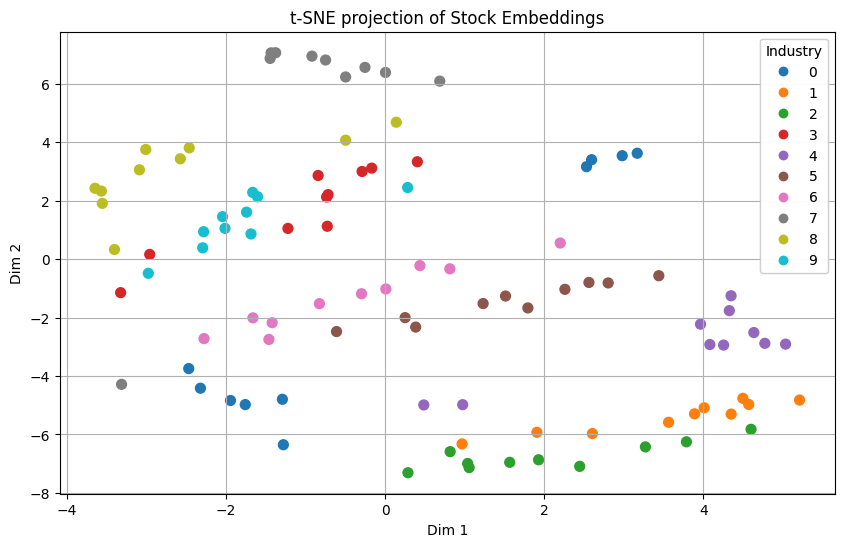

In [187]:
# ---- Visualize embeddings using t-SNE ----
embedder.eval()
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # [100, 4]
    industry_colors = stock_to_industry.numpy()

    # Reduce to 2D using t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    stock_2d = tsne.fit_transform(stock_embeddings)

    # Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(stock_2d[:, 0], stock_2d[:, 1], c=industry_colors, cmap='tab10', s=50)
    plt.title("t-SNE projection of Stock Embeddings")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    legend1 = plt.legend(*scatter.legend_elements(), title="Industry")
    plt.gca().add_artist(legend1)
    plt.grid(True)
    plt.show()

In [188]:
import pandas as pd
import torch

# Simulation parameters
n_stocks = 100
n_quarters = 20
embedding_dim = 4  # must match your model

# Define stock IDs and quarters
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_quarters))  # Q0, Q1, ..., Q19

# Create full panel (stock x quarter)
index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Simulate predictors
df["div_yield_change"] = np.random.normal(0, 0.1, len(df))
df["ptb_change"] = np.random.normal(0, 0.1, len(df))

# Simulate Homogenous (Effects from predictors which do not depend on context)
hom_slope = 0.2

# Simulate Homogenous context predictors (Effects directly from context which do not depend on predictors)
stock_effects = {stock: np.random.normal(0, 0.1) for stock in stocks}
time_effects = {q: np.random.normal(0, 0.1) for q in quarters}

# Simulate Heterogenous predictor (Effects from predictors which are modulated by context)
stock_slopes = {stock: 0.5 + 0.3 * np.random.rand() for stock in stocks}

df["return"] = (
    df.apply(lambda row: stock_slopes[row["stock_id"]] * row["div_yield_change"], axis=1)
    + hom_slope * df["ptb_change"]
    + df["stock_id"].map(stock_effects)
    + df["quarter"].map(time_effects)
    + np.random.normal(0, 0.05, len(df))
)

df.head()


,stock_id,quarter,div_yield_change,ptb_change,return
0,Stock_0,0,0.049671,-0.067518,-0.213552
1,Stock_0,1,-0.013826,-0.014452,-0.207012
2,Stock_0,2,0.064769,-0.079242,0.097769
3,Stock_0,3,0.152303,-0.030796,-0.052194
4,Stock_0,4,-0.023415,-0.189361,-0.187846


In [189]:
import pandas as pd
import numpy as np
import torch

# Simulation parameters
n_stocks = 100
n_quarters = 20
embedding_dim = 4  # must match your model

# Define stock IDs and quarters
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_quarters))  # Q0, Q1, ..., Q19

# Assign each stock to an industry (10 industries)
industries = {stock: i // 10 for i, stock in enumerate(stocks)}  # Stock_0–9 → 0, Stock_10–19 → 1, ..., Stock_90–99 → 9

# Create full panel (stock x quarter)
index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Add industry column
df["industry"] = df["stock_id"].map(industries)

# Simulate predictors
df["div_yield_change"] = np.random.normal(0, 0.1, len(df))
df["ptb_change"] = np.random.normal(0, 0.1, len(df))

# Simulate Homogenous (Effects from predictors which do not depend on context)
hom_slope = 0.2

# Simulate Homogenous context predictors (Effects directly from context which do not depend on predictors)
stock_effects = {stock: np.random.normal(0, 0.1) for stock in stocks}
time_effects = {q: np.random.normal(0, 0.1) for q in quarters}

# Simulate Heterogenous predictor (Effects from predictors which are modulated by context)
stock_slopes = {stock: 0.5 + 0.3 * np.random.rand() for stock in stocks}

# Simulate returns
df["return"] = (
    df.apply(lambda row: stock_slopes[row["stock_id"]] * row["div_yield_change"], axis=1)
    + hom_slope * df["ptb_change"]
    + df["stock_id"].map(stock_effects)
    + df["quarter"].map(time_effects)
    + np.random.normal(0, 0.05, len(df))
)

df.head()


,stock_id,quarter,industry,div_yield_change,ptb_change,return
0,Stock_0,0,0,-0.116207,-0.039845,0.005910
1,Stock_0,1,0,0.158212,-0.044664,-0.066642
2,Stock_0,2,0,-0.039947,0.061227,0.027374
3,Stock_0,3,0,0.012919,-0.155944,-0.028442
4,Stock_0,4,0,-0.006327,-0.107772,-0.064104


In [190]:
# Convert to panel format
df = df.set_index(["stock_id", "quarter"])

# Run the fixed effects model
fixed_effects_model = PanelOLS(
    dependent=df["return"],
    exog=df[["div_yield_change", "ptb_change"]],
    entity_effects=True,
    time_effects=True
)
results = fixed_effects_model.fit(cov_type="clustered", cluster_entity=True)

# Print summary
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.6498
Estimator:                   PanelOLS   R-squared (Between):              0.0415
No. Observations:                2000   R-squared (Within):               0.3050
Date:                Sat, Apr 12 2025   R-squared (Overall):              0.2000
Time:                        21:56:59   Log-likelihood                    3207.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1743.0
Entities:                         100   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                  F(2,1879)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             1071.4
                            

In [191]:
df = df.reset_index()

# ----- Get stock embeddings from the trained model -----
embedder.eval()
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # shape: [100, 4]

# Create a DataFrame mapping stock name to its embedding
embedding_df = pd.DataFrame(stock_embeddings, columns=[f"embed_dim_{i}" for i in range(embedding_dim)])
embedding_df["stock_id"] = [f"Stock_{i}" for i in range(n_stocks)]

# ----- Merge embeddings into the panel -----
df = df.merge(embedding_df, on="stock_id", how="left")

df.head()

,stock_id,quarter,industry,div_yield_change,ptb_change,return,embed_dim_0,embed_dim_1,embed_dim_2,embed_dim_3
0,Stock_0,0,0,-0.116207,-0.039845,0.005910,0.028365,0.626124,-0.003805,-0.73686
1,Stock_0,1,0,0.158212,-0.044664,-0.066642,0.028365,0.626124,-0.003805,-0.73686
2,Stock_0,2,0,-0.039947,0.061227,0.027374,0.028365,0.626124,-0.003805,-0.73686
3,Stock_0,3,0,0.012919,-0.155944,-0.028442,0.028365,0.626124,-0.003805,-0.73686
4,Stock_0,4,0,-0.006327,-0.107772,-0.064104,0.028365,0.626124,-0.003805,-0.73686


In [192]:
# Use stock_id and quarter as context
context_df = df[["embed_dim_0", "embed_dim_1", "embed_dim_2", "embed_dim_3", "quarter"]].copy()
context_df["quarter"] = context_df["quarter"].astype(int)

# Predictors
X = df[["div_yield_change", "ptb_change"]].values
Y = df["return"].values.reshape(-1, 1)
C = context_df.values  # context = (stock_id, quarter)